# salesForecasting
- Sara Echeverría 21371
- Ricardo Mendez 21289
- Melissa Pérez 21385

Repository link: https://github.com/bl33h/salesForecasting

## Task 1: Práctica

In [18]:
# librerías
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam


In [5]:
# configuración para uso de GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

### 1. Preparación de datos:

In [6]:
# carga de datos
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [7]:
# inspección inicial de los datos
print("Train DataFrame shape:", train_df.shape)
print("Test DataFrame shape:", test_df.shape)

train_df.head()

Train DataFrame shape: (913000, 4)
Test DataFrame shape: (45000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [8]:
# valores faltantes en cada dataset
print("Valores faltantes en Train:")
print(train_df.isnull().sum())

print("\nValores faltantes en Test:")
print(test_df.isnull().sum())

Valores faltantes en Train:
date     0
store    0
item     0
sales    0
dtype: int64

Valores faltantes en Test:
id       0
date     0
store    0
item     0
dtype: int64


In [9]:
scaler = MinMaxScaler()
train_df['sales_scaled'] = scaler.fit_transform(train_df[['sales']])

# Display the first few rows of the train dataset after normalization
df_prepared = train_df.head()
print(df_prepared)

         date  store  item  sales  sales_scaled
0  2013-01-01      1     1     13      0.056277
1  2013-01-02      1     1     11      0.047619
2  2013-01-03      1     1     14      0.060606
3  2013-01-04      1     1     13      0.056277
4  2013-01-05      1     1     10      0.043290


### 2. Preprocesamiento de datos

In [10]:
train_df = train_df.sort_values(by='date')

# 90 días como 3 meses
test_size = 90 * len(train_df['store'].unique()) * len(train_df['item'].unique())

# división de entrenamiento, validación y prueba
train_data = train_df.iloc[:-test_size]
test_data = train_df.iloc[-test_size:]

# tamaño del conjunto de validación como el 10% del conjunto de entrenamiento
val_size = int(0.1 * len(train_data))
val_data = train_data.iloc[-val_size:]
train_data = train_data.iloc[:-val_size]

print("Training set size:", train_data.shape)
print("Validation set size:", val_data.shape)
print("Test set size:", test_data.shape)

Training set size: (781200, 5)
Validation set size: (86800, 5)
Test set size: (45000, 5)


In [11]:
# crear secuencias de ventas históricas y objetivos futuros
def create_sequences(data, window_size=30, forecast_size=90):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_size):
        X.append(data.iloc[i:i + window_size]['sales_scaled'].values)
        y.append(data.iloc[i + window_size:i + window_size + forecast_size]['sales_scaled'].values)
    return np.array(X), np.array(y)

# generación de secuencias
window_size = 30
forecast_size = 90

X_train, y_train = create_sequences(train_data, window_size, forecast_size)
X_val, y_val = create_sequences(val_data, window_size, forecast_size)
X_test, y_test = create_sequences(test_data, window_size, forecast_size)

print("Training sequences:", X_train.shape, y_train.shape)
print("Validation sequences:", X_val.shape, y_val.shape)
print("Test sequences:", X_test.shape, y_test.shape)

Training sequences: (781080, 30) (781080, 90)
Validation sequences: (86680, 30) (86680, 90)
Test sequences: (44880, 30) (44880, 90)


### 3. Selección de modelo: LSTM
### 4. Arquitectura del modelo

In [12]:
# input shape
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

def create_lstm_model(input_shape):
    model = Sequential()

    # primera capa
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape, recurrent_activation='sigmoid', implementation=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # segunda capa
    model.add(LSTM(50, return_sequences=False, recurrent_activation='sigmoid', implementation=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # capa Densa final para predicción
    model.add(Dense(forecast_size, activation='relu'))

    # compilar el modelo
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

In [13]:
# crear el modelo
input_shape = (X_train.shape[1], X_train.shape[2])
model = create_lstm_model(input_shape)

model.summary()

c:\Users\Mendez\Desktop\U\DL\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 50)         │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 90)             │         4,590 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,590 (139.02 KB)

 Trainable params: 35,390 (138.24 KB)

 Non-trainable params: 200 (800.00 B)

### 5. Entrenamiento del modelo

In [14]:
# early stopping para detener el entrenamiento si el modelo no mejora
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/20
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 210s 17ms/step - loss: 0.0189 - val_loss: 0.0215
Epoch 2/20
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 204s 17ms/step - loss: 0.0121 - val_loss: 0.0206
Epoch 3/20
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 205s 17ms/step - loss: 0.0121 - val_loss: 0.0203
Epoch 4/20
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 204s 17ms/step - loss: 0.0121 - val_loss: 0.0208
Epoch 5/20
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 208s 17ms/step - loss: 0.0121 - val_loss: 0.0205
Epoch 6/20
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 204s 17ms/step - loss: 0.0121 - val_loss: 0.0203
Epoch 7/20
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 204s 17ms/step - loss: 0.0121 - val_loss: 0.0203
Epoch 8/20
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 204s 17ms/step - loss: 0.0121 - val_loss: 0.0204
Epoch 9/20
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 204s 17ms/step - loss: 0.0121 - val_loss: 0.0208
Epoch 10/20
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 204s 17ms/step - loss: 0.0121 - val_loss: 0.0206
Epoch 11/20
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 205s 17ms/step - loss: 0

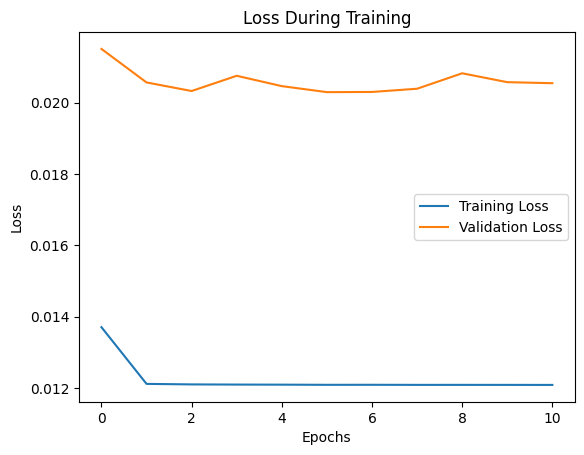

In [15]:
# grafica de la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 6. Evaluación del modelo:

In [16]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

1403/1403 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0151
Test Loss: 0.01377962902188301


### 7. Ajuste de hiperparámetros:

In [20]:
def create_lstm_model(input_shape, lstm_units=100, dropout_rate=0.3, lr = 0.001):
    model = Sequential()

    # primera capa
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=input_shape, recurrent_activation='sigmoid', implementation=2))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # segunda capa
    model.add(LSTM(lstm_units, return_sequences=False, recurrent_activation='sigmoid', implementation=2))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # capa Densa final para predicción
    model.add(Dense(forecast_size, activation='relu'))

    # compilar el modelo
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# crear el modelo con nuevos hiperparámetros
input_shape = (X_train.shape[1], X_train.shape[2])
model = create_lstm_model(input_shape, lstm_units=100, dropout_rate=0.3, lr=0.001)

model.summary()

# early stopping para detener el entrenamiento si el modelo no mejora
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# entrenar el modelo con nuevos hiperparámetros
history = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping])

c:\Users\Mendez\Desktop\U\DL\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 30, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 30, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 90)             │         9,090 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,090 (512.07 KB)

 Trainable params: 130,690 (510.51 KB)

 Non-trainable params: 400 (1.56 KB)

Epoch 1/30
6103/6103 ━━━━━━━━━━━━━━━━━━━━ 318s 52ms/step - loss: 0.0254 - val_loss: 0.0217
Epoch 2/30
6103/6103 ━━━━━━━━━━━━━━━━━━━━ 311s 51ms/step - loss: 0.0121 - val_loss: 0.0203
Epoch 3/30
6103/6103 ━━━━━━━━━━━━━━━━━━━━ 309s 51ms/step - loss: 0.0121 - val_loss: 0.0205
Epoch 4/30
6103/6103 ━━━━━━━━━━━━━━━━━━━━ 308s 50ms/step - loss: 0.0121 - val_loss: 0.0203
Epoch 5/30
6103/6103 ━━━━━━━━━━━━━━━━━━━━ 307s 50ms/step - loss: 0.0121 - val_loss: 0.0205
Epoch 6/30
6103/6103 ━━━━━━━━━━━━━━━━━━━━ 308s 50ms/step - loss: 0.0121 - val_loss: 0.0205
Epoch 7/30
6103/6103 ━━━━━━━━━━━━━━━━━━━━ 309s 51ms/step - loss: 0.0121 - val_loss: 0.0205


### 8. Forecasting:

In [21]:
predictions = model.predict(X_test)

predictions_original_scale = scaler.inverse_transform(predictions)

print("Predicciones (primeras 5):")
print(predictions_original_scale[:5])

1403/1403 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step
Predicciones (primeras 5):
[[56.39936  56.849506 55.664658 55.59655  56.3472   56.455868 57.255333
  56.63854  56.81064  56.750095 56.59167  56.468323 56.51964  55.986504
  56.599075 57.43633  56.34009  57.518215 56.900433 57.119884 57.71704
  56.89719  56.745384 56.404057 56.73488  56.504143 55.489292 55.57819
  56.82369  56.85178  57.06265  55.361988 57.510414 57.22554  56.49086
  56.280323 56.568096 57.1178   55.846054 57.942017 56.705692 57.868843
  56.497135 56.08337  55.778152 56.393375 55.739563 55.978672 56.059334
  56.750866 56.110023 56.125942 55.968704 58.294262 54.73531  57.238777
  56.944916 55.446182 57.0476   56.84374  57.039555 55.76931  57.13826
  56.073948 57.28804  55.865204 57.716557 55.809353 57.51435  55.638294
  57.113247 56.49795  56.479797 56.476353 56.617416 56.3049   55.64326
  56.786633 56.404236 56.85825  56.434948 56.74008  57.219063 55.047638
  56.181183 56.15974  57.31508  55.5839   55.745125 55.529335]
 [55.43

### 9. Visualización:

In [ ]:
num_predictions = 100  # Number of predictions to visualize
actual_sales = scaler.inverse_transform(y_test[:num_predictions])
predicted_sales = predictions_original_scale[:num_predictions]

# Plot the actual vs predicted sales
plt.figure(figsize=(14, 7))
plt.plot(actual_sales.flatten(), label='Actual Sales')
plt.plot(predicted_sales.flatten(), label='Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

### 10. Interpretabilidad del modelo:

## Task 2: Teoría

### 1. ¿Cuál es el problema del gradiente de fuga en las redes LSTM y cómo afecta la efectividad de LSTM para el pronóstico de series temporales?
En este contexto, al gradiente utilizado en las LSTM dificulta aprender dependencias a largo plazo. Su arquitectura ayudn a retener información relevante, mejorando el pronóstico de series temporales.

### 2. ¿Cómo se aborda la estacionalidad en los datos de series temporales cuando se utilizan LSTM para realizar pronósticos y qué papel juega la diferenciación en el proceso?
Esta se maneja por medio de la diferenciación para eliminar patrones estacionales, permitiendo un pronóstico más efectivo al enfocar las dependencias temporales significativas.

### 3. ¿Cuál es el concepto de "tamaño de ventana" en el pronóstico de series temporales con LSTM y cómo afecta la elección del tamaño de ventana a la capacidad del modelo para capturar patrones a corto y largo plazo?
Este hace referencia a la cantidad de datos pasados que usa el LSTM para predecir futuros valores. Ventanas más grandes capturan patrones a largo plazo, mientras que ventanas más pequeñas se enfocan en patrones recientes. En ambos casos puede haber pérdida de información.